angles = [0.         0.34906585 0.52359878 0.34906585]


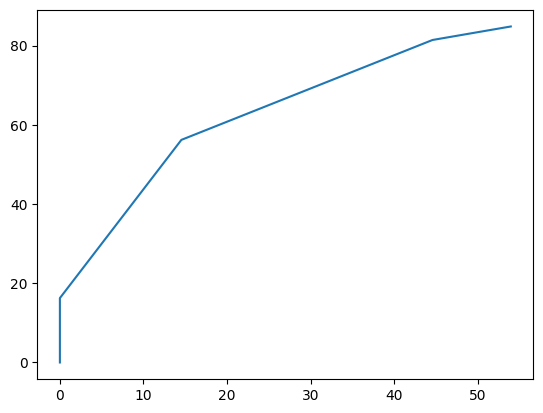

In [ ]:
import numpy as np 
import math 
import matplotlib.pyplot as plt
### Define Robot Body
# Link length 
L0 = 162.5
L1 = 425
L2 = 392.2
L3 = 99.7 
links= [L0/10,L1/10,L2/10,L3/10]
##returns array with position for each link,
    #angels in radians links in mm
def forewardkin2(links,angles):
    print('angles =', angles)
    #end of each Link
    Ex0 =  0# base 
    Ey0 = links[0]
    Ey1 = math.cos(angles[1])*links[1] + Ey0
    Ex1 = math.sin(angles[1])*links[1] + Ex0
    Ey2 = math.cos(angles[1]+angles[2])*links[2] + Ey1
    Ex2 = math.sin(angles[1]+angles[2])*links[2] + Ex1
    Ey3 = math.cos(angles[1]+angles[2]+ angles[3]) * links[3] + Ey2
    Ex3 = math.sin(angles[1]+angles[2]+angles[3]) * links[3] + Ex2 
    #return np.array( [[Ex0,Ey0],[Ex1,Ey1],[Ex2,Ey2],[Ex3,Ey3]])
    return np.array([[0,Ex0,Ex1,Ex2,Ex3],[0,Ey0,Ey1,Ey2,Ey3]])

angles = np.deg2rad([0,20,30,20])
joints = forewardkin2(links, angles)
#print(joints)
plt.figure
plt.plot(joints[0],joints[1])

In [30]:
import gymnasium as gym 
from gymnasium import spaces 
import numpy as np 


class TwoD_Robot(gym.Env): 
    def __init__(self):

        self.L1 = 42.5 
        self.L2 = 39.22 
        self.L3 = 9.97

        goal_init = [0,30,np.pi] 

        self.goal = np.array(goal_init)
        # Action space: [delta_Theta1, delta_Theta2, delta_Theta3]
        self.action_space = spaces.Box(low= -0.1, high =0.1, shape = (3,))

        # observation space, x,y,thetaE,theta1,theta2,theta3, goalx,goaly,goaltheta
        # endeffektor pose, joint angles,  
        self.observation_space = spaces.Box(
            low=np.array([-100, -100, -2 * np.pi, -np.pi, -np.pi, -np.pi, -100, -100, -2 * np.pi]),
            high=np.array([100, 100, 2 * np.pi, np.pi, np.pi, np.pi, 100, 100, 2 * np.pi]),
            shape=(9,),
            dtype= float 
        )

        
        #initial joint angles 
        self.theta = np.array([0.0,0.0,0.0])
        self.ee_pose = self.forward_kinematics(self.theta)

    def forward_kinematics(self,theta):
        """compute Endeffector Pose and returns x,y and theta (angles). zero pose is a vertical line"""
        x = (self.L1 * np.sin(theta[0]) +
            self.L2 * np.sin(theta[0] + theta[1]) +
            self.L3 * np.sin(theta[0] + theta[1] + theta[2]))
        y = (self.L1 * np.cos(theta[0]) +
            self.L2 * np.cos(theta[0] + theta[1]) +
            self.L3 * np.cos(theta[0] + theta[1] + theta[2]))
        theta_E = theta[0] + theta[1] + theta[2]
        return np.array([x,y,theta_E])

    def reset(self, seed=None):
        #returns new random state and emptyinfo 

        self.np_random, _ = gym.utils.seeding.np_random(seed)  # This line handles the seeding
        self.theta = np.random.uniform(-np.pi, np.pi, size = 3)
        self.ee_pose = self.forward_kinematics(self.theta)

        rad = np.sqrt(np.random.uniform(0,1))*75 
        angle = np.random.uniform(0,2*np.pi)
        x = rad * np.cos(angle)
        y = rad * np.sin(angle)
        theta_e = angle 
        self.goal = (x,y,theta_e)
        return np.concatenate((self.ee_pose, self.theta, self.goal), axis=0) , {}

    def step(self,action):
        # perform action and oberve 
        self.theta += action 
        self.theta = np.clip(self.theta, -np.pi, np.pi)  # Keep angles in range
        self.ee_pose = self.forward_kinematics(self.theta)
        observation = np.concatenate((self.ee_pose, self.theta, self.goal), axis=0)

        # calculate reward
        distance_to_goal = np.linalg.norm(self.ee_pose[:2] - self.goal[:2])
        angle_distance = np.abs(self.ee_pose[2] - self.goal[2])
        r_d = - distance_to_goal* 10
        r_a = - angle_distance / np.pi * 10

        if (distance_to_goal < 2 and
            angle_distance < np.pi/8):
            r_done = 500 
            done = True
        else: 
            done = False
            r_done = 0 

        reward= r_d + r_a + r_done 

        return observation, reward, done
    
    def render(self): 

        angles = self.theta
        links = np.array([self.L1,self.L2,self.L3])
        #end of each Link
        Ey1 = math.cos(angles[0])*links[0]
        Ex1 = math.sin(angles[0])*links[0]
        Ey2 = math.cos(angles[0]+angles[1])*links[1] + Ey1
        Ex2 = math.sin(angles[0]+angles[1])*links[1] + Ex1
        Ey3 = math.cos(angles[0]+angles[1]+ angles[2]) * links[2] + Ey2
        Ex3 = math.sin(angles[0]+angles[1]+angles[2]) * links[2] + Ex2 

        joints = np.array([[0,Ex1,Ex2,Ex3],[0,Ey1,Ey2,Ey3]])
        plt.figure
        plt.plot(joints[0],joints[1])

        


# Test Environment 

Reward: -1187.1809119329573
Reward: -1186.8925840833492
Reward: -1164.5794261308142
Reward: -1168.9667827041387
Reward: -1149.655509324148
Reward: -1133.2061320343603
Reward: -1145.7761849099543
Reward: -1156.0630294084813
Reward: -1155.3643648801412
Reward: -1157.2538855892699
Reward: -1147.7576195303964
Reward: -1157.3109091685878
Reward: -1150.2401602668624
Reward: -1129.5725493347798
Reward: -1126.6186830174227
Reward: -1141.6439185721595
Reward: -1114.6538770966847
Reward: -1117.5108601383495
Reward: -1107.7842527144023
Reward: -1123.9851347098586
Reward: -1120.6578936635387
Reward: -1111.5282551976347
Reward: -1118.1982076960587
Reward: -1133.5340682750348
Reward: -1148.530087963553
Reward: -1131.7947996310095
Reward: -1143.0649331321042
Reward: -1159.1524122802205
Reward: -1130.7013632861094
Reward: -1115.6551190831071
Reward: -1135.1596777731174
Reward: -1105.6436307106183
Reward: -1082.4205949946534
Reward: -1062.482985655396
Reward: -1073.425048168547
Reward: -1091.8509049776

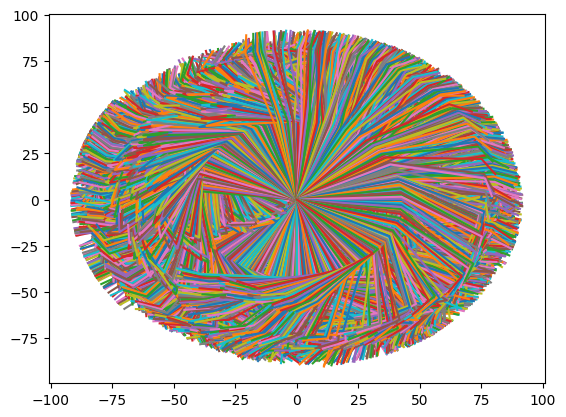

In [28]:
if __name__ == "__main__":
    env = TwoD_Robot()
    observation = env.reset()
    done = False

    while not done:
        action = env.action_space.sample()  # Random action
        observation, reward, done  = env.step(action)
        env.render()
        print(f"Reward: {reward}")




In [31]:
from stable_baselines3.common.env_checker import check_env

env = TwoD_Robot()
print(env.observation_space)
print("Low bounds:", env.observation_space.low)
print("High bounds:", env.observation_space.high)
check_env(env)


Box([-100.         -100.           -6.28318531   -3.14159265   -3.14159265
   -3.14159265 -100.         -100.           -6.28318531], [100.         100.           6.28318531   3.14159265   3.14159265
   3.14159265 100.         100.           6.28318531], (9,), float64)
Low bounds: [-100.         -100.           -6.28318531   -3.14159265   -3.14159265
   -3.14159265 -100.         -100.           -6.28318531]
High bounds: [100.         100.           6.28318531   3.14159265   3.14159265
   3.14159265 100.         100.           6.28318531]


/home/cecily/MasterThesis_Cy/venv/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:461: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


AssertionError: The `step()` method must return five values: obs, reward, terminated, truncated, info. Actual: 3 values returned.

In [5]:
from stable_baselines3 import PPO

# Create and wrap the environment
env = TwoD_Robot()
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=1000)

# Test the trained model
obs = env.reset()
for _ in range(100):
    action, _states = model.predict(obs)
    obs, rewards, done, _ = env.step(action)
    if done:
        break


2024-12-13 17:25:11.892439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734081911.905831 1336543 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734081911.909839 1336543 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 17:25:11.924109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cecily/MasterThesis_Cy/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision 

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AssertionError: The algorithm only supports (<class 'gymnasium.spaces.box.Box'>, <class 'gymnasium.spaces.discrete.Discrete'>, <class 'gymnasium.spaces.multi_discrete.MultiDiscrete'>, <class 'gymnasium.spaces.multi_binary.MultiBinary'>) as action spaces but Box(-0.1, 0.1, (3,), float32) was provided